## Environment Check

In [ ]:
import torch
# checking if CUDA is available and printing the version
# also doing a simple tensor operation to verify functionality
# Should be 12.4
print("torch.version.cuda:", torch.version.cuda)  
# should be True   
print("cuda_available:", torch.cuda.is_available()) 
x = torch.randn(30,30, device="cuda")
y = torch.mm(x,x)
print("Norm:", y.norm().item())
import os
# checking if the environment variable is set because of a bug in Collab
os.environ["WANDB_DISABLED"] = "true"
import shutil

# Set the base directory where the folders are located
base_dir = '.'   

# Curated allowlist of training/output artifacts that tend to fill the disk.
# These are created by different model families (BERTurk, XLM-R, mBERT, Mistral)
# and by each CV fold. Removing them keeps storage usage under control. 
# Because of JHUB disk space issues, we need to delete these folders before each run.
folders_to_delete = [
    'bias_classifier',
    'bias_classifier_model',
    'bias_classifier_xlmroberta',
    'hate_classifier_model',
    'optuna_bias_classifier',
    'sentiment_classifier_model_fast',
    'sentiment_model_fasttrain',
    'xlmr_bias_classifier_model',
    'mbert_bias_classifier',
    'xlmr_bias_classifier',
    'tmp_trainer',
    'mistral_bias_classifier',
    'mistral_bias_classifier_peft',
    #berturk
    'cv_fold_1', 'cv_fold_2', 'cv_fold_3', 'cv_fold_4', 'cv_fold_5',
    #xlmr
    'xlmr_cv_fold_1', 'xlmr_cv_fold_2', 'xlmr_cv_fold_3', 'xlmr_cv_fold_4', 'xlmr_cv_fold_5',
    #mbert
    'mbert_cv_fold_1', 'mbert_cv_fold_2', 'mbert_cv_fold_3', 'mbert_cv_fold_4', 'mbert_cv_fold_5',
    #mistral
    'mistral_cv_fold_1', 'mistral_cv_fold_2', 'mistral_cv_fold_3', 'mistral_cv_fold_4', 'mistral_cv_fold_5',
]

# iterate through the list and delete each folder if it exists
for folder_name in folders_to_delete:
    full_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(full_path):
        shutil.rmtree(full_path)
        print(f"Deleted folder: {folder_name}")
    else:
        print(f"Not found, skipping: {folder_name}")




torch.version.cuda: 12.4
cuda_available: True
Norm: 174.1509552001953
Not found, skipping: bias_classifier
Not found, skipping: bias_classifier_model
Not found, skipping: bias_classifier_xlmroberta
Not found, skipping: hate_classifier_model
Not found, skipping: optuna_bias_classifier
Not found, skipping: sentiment_classifier_model_fast
Not found, skipping: sentiment_model_fasttrain
Not found, skipping: xlmr_bias_classifier_model
Not found, skipping: mbert_bias_classifier
Not found, skipping: xlmr_bias_classifier
Not found, skipping: tmp_trainer
Not found, skipping: mistral_bias_classifier
Not found, skipping: mistral_bias_classifier_peft
Not found, skipping: cv_fold_1
Not found, skipping: cv_fold_2
Not found, skipping: cv_fold_3
Not found, skipping: cv_fold_4
Not found, skipping: cv_fold_5
Deleted folder: xlmr_cv_fold_1
Not found, skipping: xlmr_cv_fold_2
Not found, skipping: xlmr_cv_fold_3
Not found, skipping: xlmr_cv_fold_4
Not found, skipping: xlmr_cv_fold_5
Not found, skipping: mbe

## System Dependencies

In [ ]:
# these are the packages we need to install for the notebook to run properly
# if you are running this notebook in a new environment, simply change the first_time variable to True
# and run the cell to install the required packages
# after running this cell you should set first_time to False and restart the kernel

import sys
first_time=False
if (first_time):
    ! pip install pandas
    ! pip install datasets
    ! pip install transformers
    ! pip install scikit-learn
    ! pip install evaluate
    ! pip install --upgrade torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
    ! pip install --upgrade transformers
    ! pip install "accelerate>=0.26.0"
    ! pip install seaborn
    ! pip install faiss-cpu sentence_transformers
    ! pip install nest_asyncio
    ! pip install bitsandbytes peft





# Annotation + Cleaning

In [ ]:
# News Preprocessing Script
# reproducible preprocessing for news articles

import hashlib, os, pandas as pd, uuid

RAW_CSV         = "all_sources_combined_by_keywords.csv"
# Pre-processed CSV file 
# output of the preprocessing script
PROC_CSV        = "news_preprocessed.csv"   

if os.path.exists(PROC_CSV):
    df = pd.read_csv(PROC_CSV)
    print("Pre-processed data loaded:", df.shape)
else:
    # load raw CSv file and keep only the first 7 columns 
    # (since we only need those and if there is any scraping error, this helps)
    df_raw = pd.read_csv(RAW_CSV).iloc[:, :7]        
    # whitelist of allowed sources
    allowed_sources = ["BirGün", "Sözcü", "Habertürk","Euronews",
                       "Milliyet", "Diriliş Postası"]
    df_raw = df_raw[df_raw["Source"].isin(allowed_sources)].reset_index(drop=True)

    # keep only selected columns
    cols_keep = ["Source", "Title", "URL", "Content", "search_keyword"]
    df = df_raw[cols_keep].copy()

    # drop articles which contain 30 words or less in Content
    df = df[df["Content"].apply(lambda x: isinstance(x, str) and len(x.split()) >= 30)]
    df.reset_index(drop=True, inplace=True)

    # inherit outlet-level bias labels
    bias_map = {"BirGün":"left","Sözcü":"left",
                "Habertürk": "center","Euronews": "center",
                "Milliyet":"right","Diriliş Postası":"right"}
    df["bias_label"] = df["Source"].map(bias_map)

    # 4) DETERMINISTIC news_id
    # if URL is available, use uuid5 with URL as namespace
    # if URL is not available, use sha1-hex of Content (first 16 chars)
    # this ensures that the same article will always have the same ID
    # and we can merge datasets without duplicates
    
    def make_id(row):
        if isinstance(row["URL"], str) and row["URL"]:
            return str(uuid.uuid5(uuid.NAMESPACE_URL, row["URL"].strip()))
        # if URL is missing sha1(content) first 16 chars
        return hashlib.sha1(row["Content"].encode("utf-8")).hexdigest()[:16]

    df["news_id"] = df.apply(make_id, axis=1)

    # Save
    df.to_csv(PROC_CSV, index=False)
    print("Pre-processed data loaded:", PROC_CSV, df.shape)


 Pre-processed data loaded: (2913, 7)


In [ ]:
# Check the pre-processed data
df.head()

,Source,Title,URL,Content,search_keyword,bias_label,news_id
0,Diriliş Postası,"Bakan Bolat: Enerji konusunda, Türkiye-Rusya i...",https://www.dirilispostasi.com/bakan-bolat-ene...,"Ticaret Bakanı Ömer Bolat, Rusya'nın Türkiye i...",rusya,right,243d997d-a7de-534c-9109-8df84bade996
1,Diriliş Postası,Ukrayna: Rusya'nın Marinovka askeri havaalanın...,https://www.dirilispostasi.com/ukrayna-rusyani...,Ukrayna Silahlı Kuvvetleri ile Ukrayna Güvenli...,rusya,right,f227b308-d925-56d7-bd1e-9ddd51543177
2,Diriliş Postası,Türkiye ile Rusya arasında KEK Protokolü imzal...,https://www.dirilispostasi.com/turkiye-ile-rus...,"Türkiye ile Rusya arasında, Türk-Rus Ticari ve...",rusya,right,b0df1fe9-f802-5cde-9b8f-68cbda1b3b36
3,Diriliş Postası,Rusya: Türkiye’ye misafirperverliğinden ve des...,https://www.dirilispostasi.com/rusya-turkiyeye...,Rusya Dışişleri Bakanlığı Sözcüsü Mariya Zahar...,rusya,right,41bbadfe-fb0f-5627-89de-4c5d79edbca5
4,Diriliş Postası,Rusya: Donetsk'te 2 yerleşim yeri kontrolümüze...,https://www.dirilispostasi.com/rusya-donetskte...,"Rusya Savunma Bakanlığı, Donetsk bölgesindeki ...",rusya,right,d24ec5e0-db6e-5e96-afbe-ceae5ca2edae


### CV Train test split

In [ ]:
# set a random seed for reproducibility
SEED = 42
# label mapping for bias labels
label2id = {"left": 0, "center": 1, "right": 2}
id2label = {v: k for k, v in label2id.items()}

# filter to known labels and add integer label column
df = df[df["bias_label"].isin(label2id)].copy()
df["label"] = df["bias_label"].map(label2id)

from sklearn.model_selection import train_test_split

# stable 80/20 split with stratification and fixed seed
temp_df, test_df = train_test_split(
    df[["Content", "label"]],
    test_size=0.20,
    random_state=SEED,
    stratify=df["label"]
)


print(f"Train+Val (temp_df): {temp_df.shape}, Test: {test_df.shape}")

Train+Val (temp_df): (2330, 2), Test: (583, 2)


# 2. Model Fine-Tuning

### BerTTurk CV Ensemble

In [ ]:
import pandas as pd, numpy as np, torch, evaluate
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Config
# Model and training parameters
# These parameters can be adjusted based on the model and dataset size
# and the available computational resources (GPU memory)
MODEL_NAME      = "dbmdz/bert-base-turkish-uncased"
MAX_LENGTH      = 128
BATCH_SIZE      = 16
# Number of epochs for training
NUM_EPOCHS      = 20
SEED            = 42
# Number of CV splits
N_SPLITS        = 5

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# tokenize the text with max length, keep truncation and padding identical
def tokenize(x):
    return tokenizer(x["Content"],
                     truncation=True,
                     padding="max_length",
                     max_length=MAX_LENGTH)

# load evaluation metrics
accuracy = evaluate.load("accuracy")
f1       = evaluate.load("f1")

# compute metrics for evaluation (accuracy and F1-macro)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy" : accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro" : f1.compute(predictions=preds, references=labels,
                                average="macro")["f1"]
    }

# Cross-validation setup

# using the shared train+val dataset (temp_df)
X, y    = temp_df["Content"].values, temp_df["label"].values
skf     = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# collected for CV summary and test-time ensemble
fold_results, best_ckpts = [], []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== FOLD {fold}/{N_SPLITS} =====")

    # Build HuggingFace Datasets for train and validation
    train_ds = Dataset.from_pandas(
        temp_df.iloc[tr_idx].reset_index(drop=True)
    ).map(tokenize, batched=True).remove_columns(["Content"]).with_format("torch")

    val_ds = Dataset.from_pandas(
        temp_df.iloc[val_idx].reset_index(drop=True)
    ).map(tokenize, batched=True).remove_columns(["Content"]).with_format("torch")

    # new model for each fold, label maps fixed for consistency
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
    )

    # TrainingArguments for the Trainer
    args = TrainingArguments(
        output_dir        = f"./cv_fold_{fold}",
        eval_strategy="epoch",
        logging_strategy  ="epoch",
        save_strategy     ="epoch",
        save_total_limit  = 1,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better = False,
        learning_rate     = 1e-5,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size =BATCH_SIZE,
        num_train_epochs  = NUM_EPOCHS,
        weight_decay      = 0.05,
        seed              = SEED,
        report_to         = []
    )

    # Trainer setup
    # Early stopping on validation loss 
    # Patience: 2 epochs
    trainer = Trainer(model=model,
                      args=args,
                      train_dataset=train_ds,
                      eval_dataset =val_ds,
                      tokenizer    =tokenizer,
                      compute_metrics=compute_metrics,
                      callbacks=[EarlyStoppingCallback(2)])
    # Train the model
    trainer.train()
    fold_results.append(trainer.evaluate())

    # track best checkpoint path for this fold
    best_ckpts.append(trainer.state.best_model_checkpoint)

# CV Summary
cv_df = pd.DataFrame(fold_results)
print("\n===== CV Mean Scores =====")
print(cv_df.mean())




# Hold out test set evaluation
test_ds = Dataset.from_pandas(
    test_df.reset_index(drop=True)
).map(tokenize, batched=True).remove_columns(["Content"]).with_format("torch")

# collecting per-fold logits on the test set
all_logits = []
for pth in best_ckpts:
    m   = AutoModelForSequenceClassification.from_pretrained(
              pth, num_labels=3, id2label=id2label, label2id=label2id)
    tr  = Trainer(model=m, tokenizer=tokenizer)
    prd = tr.predict(test_ds)
    all_logits.append(prd.predictions)          

# mean-logits to argmax 
# soft voting without argmax preserves class order
avg_logits   = np.mean(all_logits, axis=0)
y_pred_ens   = np.argmax(avg_logits, axis=1)
y_true       = test_ds["label"]                

print("\n ENSEMBLE Classification Report:")
print(classification_report(y_true, y_pred_ens,
                            target_names=[id2label[i] for i in range(3)]))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred_ens))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



===== FOLD 1/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-9-3993701628.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.021300,0.892899,0.579399,0.581390
2,0.791100,0.766431,0.628755,0.633341
3,0.578200,0.700248,0.690987,0.695649
4,0.411800,0.670096,0.706009,0.711930
5,0.278600,0.733085,0.721030,0.720616
6,0.183100,0.825140,0.714592,0.721194



===== FOLD 2/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-9-3993701628.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.011400,0.907076,0.555794,0.557246
2,0.784700,0.808590,0.620172,0.622844
3,0.599100,0.805573,0.637339,0.636324
4,0.427700,0.739082,0.678112,0.681516
5,0.292100,0.774389,0.716738,0.718373
6,0.186700,0.852908,0.708155,0.709919



===== FOLD 3/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-9-3993701628.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.035600,0.912401,0.510730,0.478381
2,0.825300,0.759854,0.658798,0.662373
3,0.637100,0.699318,0.693133,0.693499
4,0.472300,0.668538,0.718884,0.718605
5,0.340000,0.744225,0.699571,0.702903
6,0.224600,0.779233,0.708155,0.709465



===== FOLD 4/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-9-3993701628.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.024700,0.891628,0.579399,0.572685
2,0.800200,0.725686,0.669528,0.670018
3,0.613200,0.677818,0.721030,0.719929
4,0.447200,0.658058,0.736052,0.737862
5,0.315800,0.730343,0.738197,0.740296
6,0.207300,0.835133,0.751073,0.750901



===== FOLD 5/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-9-3993701628.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.032000,0.910880,0.538627,0.528747
2,0.797100,0.745995,0.648069,0.649574
3,0.597500,0.659230,0.688841,0.699078
4,0.425500,0.642758,0.723176,0.730584
5,0.320300,0.639062,0.744635,0.748843
6,0.224400,0.709264,0.751073,0.757237
7,0.148100,0.787864,0.748927,0.753684



===== CV Mean Scores =====
eval_loss                    0.674967
eval_accuracy                0.716738
eval_f1_macro                0.719751
eval_runtime                 0.930940
eval_samples_per_second    500.649600
eval_steps_per_second       32.230400
epoch                        6.200000
dtype: float64


Map:   0%|          | 0/583 [00:00<?, ? examples/s]

/tmp/ipython-input-9-3993701628.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr  = Trainer(model=m, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/tmp/ipython-input-9-3993701628.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr  = Trainer(model=m, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/tmp/ipython-input-9-3993701628.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr  = Trainer(model=m, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/tmp/ipython-input-9-3993701628.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr  = Trainer(model=m, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/tmp/ipython-input-9-3993701628.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr  = Trainer(model=m, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



 ENSEMBLE Classification Report:
              precision    recall  f1-score   support

        left       0.78      0.64      0.70       223
      center       0.74      0.79      0.76       163
       right       0.62      0.72      0.66       197

    accuracy                           0.70       583
   macro avg       0.71      0.71      0.71       583
weighted avg       0.71      0.70      0.71       583


Confusion Matrix:
 [[142  23  58]
 [  6 128  29]
 [ 33  23 141]]


'\nmodel_final = AutoModelForSequenceClassification.from_pretrained(\n                 MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id)\n\nargs_final   = TrainingArguments(\n        output_dir="./final_model",\n        evaluation_strategy="no",\n        per_device_train_batch_size=BATCH_SIZE,\n        num_train_epochs=cv_df[\'epoch\'].mean().round().astype(int),  # → ort. best-epoch\n        learning_rate=1e-5,\n        weight_decay=0.05,\n        seed=SEED,\n        report_to=[])\nfin_trainer = Trainer(model=model_final, args=args_final,\n                      train_dataset=Dataset.from_pandas(\n                          temp_df.reset_index(drop=True)\n                      ).map(tokenize, batched=True).remove_columns(["Content"]).with_format("torch"),\n                      tokenizer=tokenizer)\nfin_trainer.train()\n'

### Baseline

In [ ]:
# Baseline pre-trained model with no fine-tuning performance
print("Baseline (pretrained) evaluation...")

baseline_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3, id2label=id2label, label2id=label2id
)

baseline_trainer = Trainer(
    model=baseline_model,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

baseline_preds = baseline_trainer.predict(test_ds)
baseline_logits  = baseline_preds.predictions
baseline_labels  = baseline_preds.label_ids
baseline_y_pred  = np.argmax(baseline_logits, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

# baseline metrics
print("BASELINE Classification report")
print(classification_report(
        baseline_labels, baseline_y_pred,
        target_names=[id2label[i] for i in range(3)]))

cm_base = confusion_matrix(baseline_labels, baseline_y_pred)




 Baseline (pretrained) evaluation...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-14-4234092723.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


 BASELINE Classification report
              precision    recall  f1-score   support

        left       0.34      0.13      0.19       223
      center       0.28      0.51      0.36       163
       right       0.27      0.27      0.27       197

    accuracy                           0.29       583
   macro avg       0.30      0.31      0.28       583
weighted avg       0.30      0.29      0.27       583



### CV-Ensemble Loss Curves

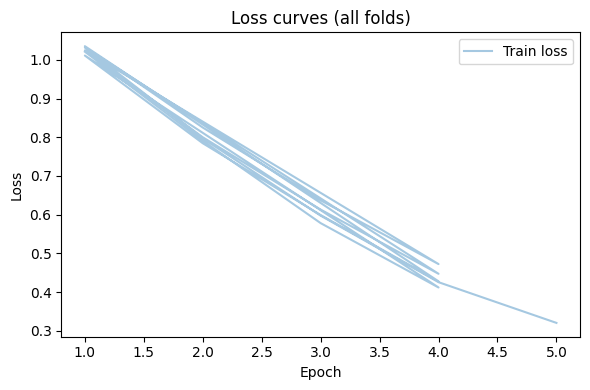

In [ ]:
# aggregate training/validation loss logs from each fold's best checkpoint

import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

hist_all = []

for pth in best_ckpts:
    # if no checkpoint was saved for this fold
    if pth is None:                
        continue
    state_file = Path(pth) / "trainer_state.json"
    with open(state_file, "r", encoding="utf-8") as f:
        # read JSON log history
        # using json.load instead of torch.load
        # because trainer_state.json is a JSON file, not a PyTorch state dict
        state = json.load(f)       
    hist_all += [x for x in state["log_history"] if "loss" in x]

# build a single df over all folds
# this will be used to plot the loss curves
hist = pd.DataFrame(hist_all)

plt.figure(figsize=(6,4))
plt.plot(hist["epoch"], hist["loss"], label="Train loss", alpha=.4)
if "eval_loss" in hist.columns:
    plt.scatter(hist["epoch"], hist["eval_loss"],
                label="Val loss", color="red", s=10)
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss curves (all folds)")
plt.legend(); plt.tight_layout(); plt.show()


### CV-Ensemble Conf Matrix


 ENSEMBLE Classification Report:
              precision    recall  f1-score   support

        left       0.78      0.64      0.70       223
      center       0.74      0.79      0.76       163
       right       0.62      0.72      0.66       197

    accuracy                           0.70       583
   macro avg       0.71      0.71      0.71       583
weighted avg       0.71      0.70      0.71       583



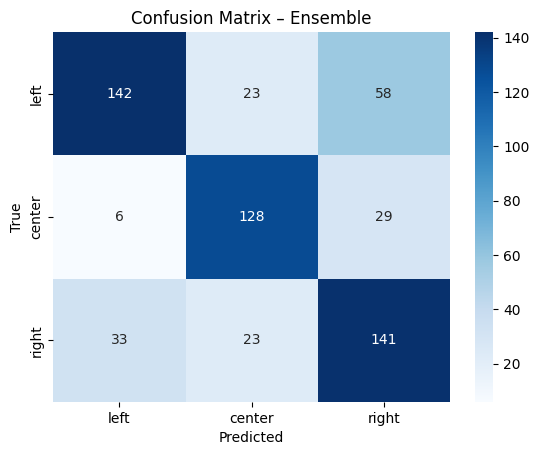

In [ ]:
# show the ensemble classificaiton report on the hold out test set
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

print("\n ENSEMBLE Classification Report:")
print(classification_report(
        y_true, y_pred_ens,
        target_names=[id2label[i] for i in range(3)]))

# compute the confusion matrix for ensemble predictions
cm_ens = confusion_matrix(y_true, y_pred_ens)

# plot the confusion matrix as a heatmap
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(3)],
            yticklabels=[id2label[i] for i in range(3)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Ensemble")
plt.show()


### The Above is BERTTurk Ensemble

### Baseline vs Ensemble Conf Matrix

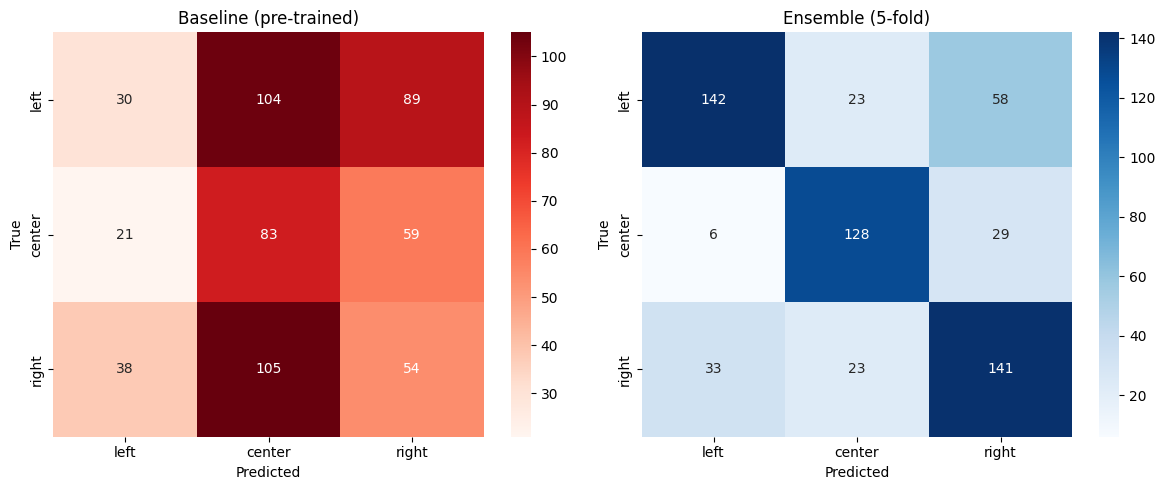

In [ ]:
# baseline vs ensemble side by side confusion matrices 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# baseline
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Reds',
            xticklabels=[id2label[i] for i in range(3)],
            yticklabels=[id2label[i] for i in range(3)],
            ax=axes[0])
axes[0].set_title("Baseline (pre-trained)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

#ensemble
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(3)],
            yticklabels=[id2label[i] for i in range(3)],
            ax=axes[1])
axes[1].set_title("Ensemble (5-fold)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout(); plt.show()


### The Above is BERTTurk Ensemble

### Logit Label Saving CV-Emsemble

In [ ]:
import numpy as np, os, pickle

model_tag = "bertturk_ens"           
np.save(f"logits_{model_tag}.npy", avg_logits)

if not os.path.exists("test_labels.npy"):
    np.save("test_labels.npy", y_true)
    print("Saved labels -> test_labels.npy")
print(f"Saved logits  to logits_{model_tag}.npy")


 Saved labels to test_labels.npy
 Saved logits  to logits_bertturk_ens.npy


### XLMRoberta CV Ensemble


In [ ]:
# imports
import random, numpy as np, pandas as pd, torch, evaluate, json
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from pathlib import Path


# config
MODEL_NAME    = "akdeniz27/xlm-roberta-base-turkish-ner"
# maximum sequence length for tokenization
MAX_LENGTH    = 128
# batch size for training and evaluation
BATCH_SIZE    = 16
# upper bound for epochs, early stopping will be used
NUM_EPOCHS    = 20           
LEARNING_RATE = 1e-5
# 5-fold cross-validation
N_SPLITS      = 5

# set random seeds for reproducibility
random.seed(SEED);  np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# tokenize with fixed max length
# truncation and padding to max length
# this ensures consistent input size for the model
def tokenize(batch):
    return tokenizer(batch["Content"],
                     truncation=True,
                     padding="max_length",
                     max_length=MAX_LENGTH)

# metrics
# load evaluation metrics
# accuracy and F1-macro
accuracy = evaluate.load("accuracy")
f1_mac   = evaluate.load("f1")

# compute accuracy and macro F1 from raw logitcs using argmax
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  accuracy.compute(predictions=preds,
                                      references=labels)["accuracy"],
        "f1_macro": f1_mac.compute(predictions=preds,
                                   references=labels,
                                   average="macro")["f1"]
    }

# Cross-validation setup
# Checkpoint Collection
X, y = temp_df["Content"].values, temp_df["label"].values
skf  = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# build the fixed hold-out test set
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))\
                 .map(tokenize, batched=True)\
                 .remove_columns(["Content"]).with_format("torch")

fold_results, best_ckpts = [], []

for fold, (tr_idx, vl_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== FOLD {fold}/{N_SPLITS} =====")

    # per fold train and validation datasets using HuggingFace Datasets
    tr_ds = Dataset.from_pandas(temp_df.iloc[tr_idx].reset_index(drop=True))\
                   .map(tokenize, batched=True)\
                   .remove_columns(["Content"]).with_format("torch")

    vl_ds = Dataset.from_pandas(temp_df.iloc[vl_idx].reset_index(drop=True))\
                   .map(tokenize, batched=True)\
                   .remove_columns(["Content"]).with_format("torch")

    # initialize a new model for each fold
    # id2label and label2id are fixed for the model
    # ignore_mismatched_sizes=True because the source checkpoint is NER
    # so we replace the head with a 3-class classification head

    model = AutoModelForSequenceClassification.from_pretrained(
                MODEL_NAME,
                num_labels=len(id2label),
                id2label={int(k): str(v) for k, v in id2label.items()},
                label2id={str(k): int(v) for k, v in label2id.items()},
                ignore_mismatched_sizes=True)

    args = TrainingArguments(
        output_dir           = f"./xlmr_cv_fold_{fold}",
        eval_strategy  = "epoch",
        logging_strategy     = "epoch",
        save_strategy        = "epoch",
        save_total_limit     = 1,
        load_best_model_at_end = True,
        metric_for_best_model  = "eval_loss",
        greater_is_better    = False,
        learning_rate        = LEARNING_RATE,
        per_device_train_batch_size = BATCH_SIZE,
        per_device_eval_batch_size  = BATCH_SIZE,
        num_train_epochs     = NUM_EPOCHS,
        weight_decay         = 0.05,
        seed                 = SEED,
        report_to            = []               # no wandb
    )

    # early stopping on validation loss
    # patience: 3 epochs
    trainer = Trainer(
        model           = model,
        args            = args,
        train_dataset   = tr_ds,
        eval_dataset    = vl_ds,
        tokenizer       = tokenizer,
        compute_metrics = compute_metrics,
        callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    fold_results.append(trainer.evaluate())
    best_ckpts.append(trainer.state.best_model_checkpoint)

    # dump raw test logits for this fold 
    # (N_test, n_labels)
    pr_test = trainer.predict(test_ds)                     
    np.save(f"logits_fold{fold}.npy",
            # raw logits
            pr_test.predictions.astype("float32"))         
    
# CV Summary
cv_df = pd.DataFrame(fold_results)
print("\n===== CV MEAN METRICS =====\n", cv_df.mean())

# Soft voting ensemble on test set
# read per fold test logits from disk and average them
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))\
                 .map(tokenize, batched=True)\
                 .remove_columns(["Content"]).with_format("torch")

all_logits = []
for fold, pth in enumerate(best_ckpts, 1):

    logits_fold = np.load(f"logits_fold{fold}.npy")
    all_logits.append(logits_fold)

avg_logits = np.mean(all_logits, axis=0)
y_pred_ens = np.argmax(avg_logits, axis=1)
y_true     = test_ds["label"]

print("\n ENSEMBLE CLASSIFICATION REPORT:\n",
      classification_report(y_true, y_pred_ens,
                            target_names=[id2label[i] for i in range(len(id2label))]))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred_ens))

Map:   0%|          | 0/583 [00:00<?, ? examples/s]


===== FOLD 1/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at akdeniz27/xlm-roberta-base-turkish-ner and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-717519805.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.092200,1.085745,0.381974,0.184265
2,1.035700,0.912843,0.555794,0.546330
3,0.865400,0.864679,0.579399,0.575382
4,0.734000,0.847104,0.637339,0.635471
5,0.625700,0.811550,0.645923,0.638062
6,0.495800,0.861110,0.675966,0.673850
7,0.416100,0.970342,0.639485,0.635305
8,0.344500,1.078556,0.624464,0.620209


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



===== FOLD 2/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at akdeniz27/xlm-roberta-base-turkish-ner and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-717519805.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.080400,1.067904,0.420601,0.313889
2,0.970800,0.948969,0.527897,0.526955
3,0.794400,0.976612,0.555794,0.547006
4,0.681800,0.895374,0.607296,0.602953
5,0.590600,0.938192,0.618026,0.610288
6,0.454900,0.970715,0.622318,0.623371
7,0.358700,1.118229,0.628755,0.629493


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



===== FOLD 3/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at akdeniz27/xlm-roberta-base-turkish-ner and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-717519805.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.102400,1.088640,0.381974,0.184265
2,1.028900,0.951358,0.489270,0.429408
3,0.933200,0.928892,0.502146,0.437806
4,0.840400,0.910120,0.577253,0.556192
5,0.742300,0.942449,0.605150,0.601981
6,0.643700,0.956593,0.603004,0.604006
7,0.526300,1.159715,0.628755,0.624284


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



===== FOLD 4/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at akdeniz27/xlm-roberta-base-turkish-ner and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-717519805.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.100700,1.085995,0.381974,0.184265
2,1.049000,0.923732,0.521459,0.472394
3,0.919300,0.940832,0.549356,0.526615
4,0.838700,0.817761,0.615880,0.620210
5,0.722300,0.925696,0.626609,0.617710
6,0.589000,0.888403,0.650215,0.652002
7,0.504300,0.929631,0.645923,0.642998


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



===== FOLD 5/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at akdeniz27/xlm-roberta-base-turkish-ner and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-717519805.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.101400,1.084213,0.384120,0.185013
2,1.039000,0.934552,0.523605,0.523081
3,0.923700,0.879529,0.564378,0.555118
4,0.784100,0.858164,0.598712,0.601150
5,0.681900,0.874084,0.641631,0.644431
6,0.568000,0.944468,0.613734,0.614911
7,0.459500,0.955868,0.643777,0.645727


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/l

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



===== CV MEAN METRICS =====
 eval_loss                    0.858594
eval_accuracy                0.609013
eval_f1_macro                0.603713
eval_runtime                 0.906400
eval_samples_per_second    514.236000
eval_steps_per_second       33.105400
epoch                        7.200000
dtype: float64


Map:   0%|          | 0/583 [00:00<?, ? examples/s]

FileNotFoundError: [Errno 2] No such file or directory: 'logits_bert_fold1.npy'

In [ ]:
# collect per-fold logits saved to disk
all_logits = []
for fold, pth in enumerate(best_ckpts, 1):
    logits_fold = np.load(f"logits_fold{fold}.npy")
    all_logits.append(logits_fold)

# mean logit voting (soft voting without softmax)
avg_logits = np.mean(all_logits, axis=0)
y_pred_ens = np.argmax(avg_logits, axis=1)
y_true     = test_ds["label"]

print("\n ENSEMBLE CLASSIFICATION REPORT:\n",
      classification_report(y_true, y_pred_ens,
                            target_names=[id2label[i] for i in range(len(id2label))]))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred_ens))



 ENSEMBLE CLASSIFICATION REPORT:
               precision    recall  f1-score   support

        left       0.74      0.62      0.67       223
      center       0.57      0.69      0.63       163
       right       0.58      0.58      0.58       197

    accuracy                           0.63       583
   macro avg       0.63      0.63      0.63       583
weighted avg       0.64      0.63      0.63       583


Confusion Matrix:
 [[139  43  41]
 [  9 113  41]
 [ 41  42 114]]


'\nbest_epoch = int(round(cv_df[\'epoch\'].mean()))\nmodel_final = AutoModelForSequenceClassification.from_pretrained(\n                 MODEL_NAME,\n                 num_labels=len(id2label),\n                 id2label={int(k): str(v) for k, v in id2label.items()},\n                 label2id={str(k): int(v) for k, v in label2id.items()},\n                 ignore_mismatched_sizes=True)\n\nargs_final = TrainingArguments(\n        output_dir="./xlmr_final_model",\n        evaluation_strategy="no",\n        per_device_train_batch_size=BATCH_SIZE,\n        num_train_epochs=best_epoch,\n        learning_rate=LEARNING_RATE,\n        weight_decay=0.05,\n        seed=SEED,\n        report_to=[]\n)\n\nfull_ds = Dataset.from_pandas(temp_df.reset_index(drop=True))                .map(tokenize, batched=True)                .remove_columns(["Content"]).with_format("torch")\n\nTrainer(model=model_final, args=args_final,\n        train_dataset=full_ds, tokenizer=tokenizer).train()\n'


 ENSEMBLE CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        left       0.74      0.62      0.67       223
      center       0.57      0.69      0.63       163
       right       0.58      0.58      0.58       197

    accuracy                           0.63       583
   macro avg       0.63      0.63      0.63       583
weighted avg       0.64      0.63      0.63       583



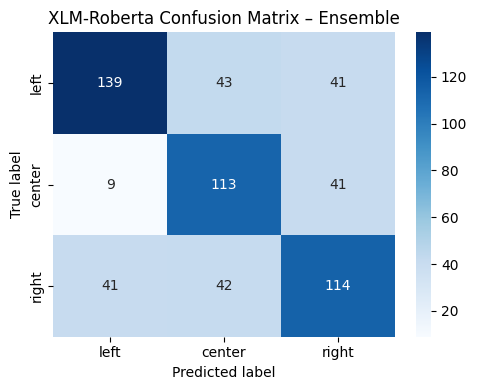

In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# report
print("\n ENSEMBLE CLASSIFICATION REPORT:")
print(classification_report(
        y_true, y_pred_ens,
        target_names=[id2label[i] for i in range(len(id2label))])
)

# confusion matrix
cm = confusion_matrix(y_true, y_pred_ens)

plt.figure(figsize=(5, 4))
sns.heatmap(cm,
            annot=True, fmt="d", cmap="Blues",
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("XLM-Roberta Confusion Matrix – Ensemble")
plt.tight_layout()
plt.show()


### Baseline

In [ ]:
# Baseline pre-trained model with no fine-tuning performance
print("\n Baseline (pre-trained) evaluation...")

baseline_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True          
)

baseline_trainer = Trainer(
    model=baseline_model,
    tokenizer=tokenizer,
    # accuracy + f1_macro
    compute_metrics=compute_metrics          
)

baseline_preds   = baseline_trainer.predict(test_ds)
baseline_logits  = baseline_preds.predictions          
baseline_labels  = baseline_preds.label_ids            
baseline_y_pred  = np.argmax(baseline_logits, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("\n BASELINE Classification Report:")
print(classification_report(
        baseline_labels,
        baseline_y_pred,
        target_names=[id2label[i] for i in range(3)]
))

cm_base = confusion_matrix(baseline_labels, baseline_y_pred)
print("\nConfusion Matrix - Baseline:\n", cm_base)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at akdeniz27/xlm-roberta-base-turkish-ner and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Baseline (pre-trained) evaluation...


/tmp/ipython-input-12-2642564806.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



 BASELINE Classification Report:
              precision    recall  f1-score   support

        left       0.33      0.00      0.01       223
      center       0.28      0.98      0.44       163
       right       0.20      0.01      0.02       197

    accuracy                           0.28       583
   macro avg       0.27      0.33      0.15       583
weighted avg       0.27      0.28      0.13       583


Confusion Matrix – Baseline:
 [[  1 216   6]
 [  1 160   2]
 [  1 194   2]]


### Baseline vs Finetuned confusion Matrix

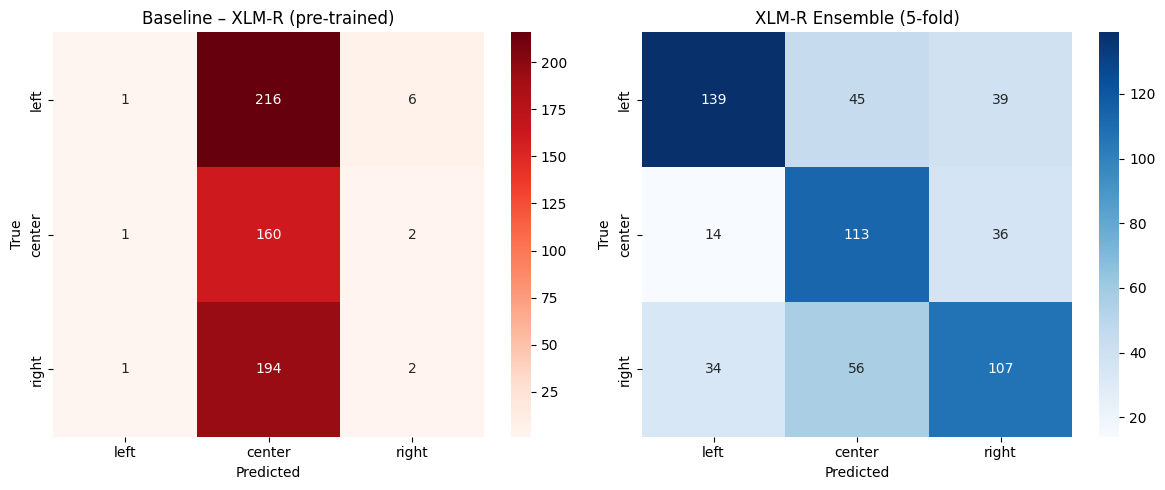

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline (pre-trained XLM-R)
sns.heatmap(
    cm_base,
    annot=True, fmt="d", cmap="Reds",
    xticklabels=[id2label[i] for i in range(3)],
    yticklabels=[id2label[i] for i in range(3)],
    ax=axes[0]
)
axes[0].set_title("Baseline – XLM-R (pre-trained)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Ensemble (5-fold fine-tuned checkpoints)
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=[id2label[i] for i in range(3)],
    yticklabels=[id2label[i] for i in range(3)],
    ax=axes[1]
)
axes[1].set_title("XLM-R Ensemble (5-fold)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


### Logit save

In [ ]:
# Save test logits
import numpy as np, os

logits      = avg_logits         
true_labels = y_true            

# tag used in the filename
model_tag   = "xlmr"     
np.save(f"logits_{model_tag}.npy", logits.astype(np.float32))
print(f" logits_{model_tag}.npy saved  | shape={logits.shape}")

# save true labels only once
if not os.path.exists("test_labels.npy"):
    np.save("test_labels.npy", true_labels.astype(np.int16))
    print(" test_labels.npy created")


 logits_xlmr.npy saved  | shape=(583, 3)


## MBErt CV Early Stop

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]


===== FOLD 1/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-18-2514413420.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args,


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.038400,1.080240,0.454936,0.339171
2,0.877800,0.877200,0.585837,0.577000
3,0.652600,0.942952,0.596567,0.598279
4,0.450600,0.893747,0.633047,0.634060



===== FOLD 2/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-18-2514413420.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args,


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.009800,0.953496,0.487124,0.480607
2,0.858800,0.894491,0.566524,0.570505
3,0.690800,0.893054,0.607296,0.597579
4,0.520400,0.895322,0.615880,0.609883
5,0.364300,1.045542,0.613734,0.611243



===== FOLD 3/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-18-2514413420.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args,


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.022200,0.985170,0.482833,0.419951
2,0.862700,0.912940,0.564378,0.564812
3,0.697900,0.878149,0.609442,0.606720
4,0.496900,0.967985,0.618026,0.615396
5,0.338500,1.123096,0.630901,0.630317



===== FOLD 4/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-18-2514413420.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args,


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.016600,0.901198,0.545064,0.532527
2,0.866300,0.831782,0.624464,0.621823
3,0.680000,0.859390,0.615880,0.615097
4,0.474300,0.856735,0.637339,0.635993



===== FOLD 5/5 =====


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-18-2514413420.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args,


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.058300,0.957751,0.515021,0.462390
2,0.939500,0.916057,0.532189,0.527016
3,0.823500,0.857701,0.598712,0.601459
4,0.672800,0.938884,0.611588,0.602291
5,0.503000,0.980727,0.615880,0.617510



===== CV MEAN METRICS (mBERT) =====
eval_loss                    0.867577
eval_accuracy                0.605150
eval_f1_macro                0.600916
eval_runtime                 0.930120
eval_samples_per_second    501.103400
eval_steps_per_second       32.260000
epoch                        4.600000
dtype: float64


Map:   0%|          | 0/583 [00:00<?, ? examples/s]

/tmp/ipython-input-18-2514413420.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trn = Trainer(model=mdl, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/tmp/ipython-input-18-2514413420.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trn = Trainer(model=mdl, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/tmp/ipython-input-18-2514413420.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trn = Trainer(model=mdl, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/tmp/ipython-input-18-2514413420.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trn = Trainer(model=mdl, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/tmp/ipython-input-18-2514413420.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trn = Trainer(model=mdl, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



 ENSEMBLE (mBERT) Classification Report:
              precision    recall  f1-score   support

        left       0.65      0.64      0.64       223
      center       0.60      0.76      0.67       163
       right       0.60      0.47      0.53       197

    accuracy                           0.62       583
   macro avg       0.61      0.62      0.61       583
weighted avg       0.62      0.62      0.61       583



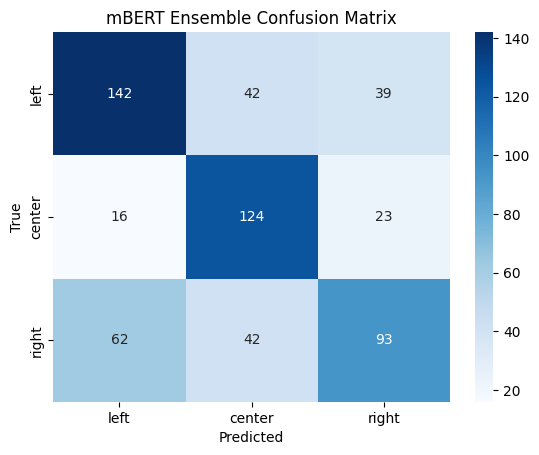

 Saved logits_mbert.npy  (and test_labels.npy if first run)


In [ ]:
# Imports
import random, numpy as np, pandas as pd, torch, evaluate, seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

# Config
MODEL_NAME     = "bert-base-multilingual-cased"
MAX_LEN        = 128
BATCH_SIZE     = 16
NUM_EPOCHS     = 20
LR             = 2e-5
SEED           = 42
N_SPLITS       = 5

# keeps run reproducible
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Tokenizer and prep
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# tokenize to a fixed max length
# same padding/truncation as before
def tokenize(batch):
    return tokenizer(batch["Content"],
                     truncation=True,
                     padding="max_length",
                     max_length=MAX_LEN)

# Metrics
accuracy = evaluate.load("accuracy")
f1_mac   = evaluate.load("f1")

# accuracy and macro F1 from logits from argmax
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy":  accuracy.compute(predictions=preds, references=labels)["accuracy"],
            "f1_macro": f1_mac.compute(predictions=preds, references=labels,
                                       average="macro")["f1"]}

# Cross Validation + Checkpoints
# 5 fold CV on the shared train + val dataset
X, y = temp_df["Content"].values, temp_df["label"].values
skf   = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_results, best_ckpts = [], []
Path("mbert_cv").mkdir(exist_ok=True)

for fold, (tr_idx, vl_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== FOLD {fold}/{N_SPLITS} =====")

    tr_ds = Dataset.from_pandas(temp_df.iloc[tr_idx].reset_index(drop=True)
            ).map(tokenize, batched=True).remove_columns(["Content"]).with_format("torch")
    vl_ds = Dataset.from_pandas(temp_df.iloc[vl_idx].reset_index(drop=True)
            ).map(tokenize, batched=True).remove_columns(["Content"]).with_format("torch")

    # fresh model for each fold
    model = AutoModelForSequenceClassification.from_pretrained(
                MODEL_NAME,
                num_labels=3,
                id2label=id2label, label2id=label2id)

    args = TrainingArguments(
        output_dir=f"./mbert_cv/fold_{fold}",
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=NUM_EPOCHS,
        weight_decay=0.05,
        seed=SEED,
        report_to=[]
    )

    # early stopping on validation loss
    # patience: 2 epochs
    trainer = Trainer(model=model, args=args,
                      train_dataset=tr_ds,
                      eval_dataset =vl_ds,
                      tokenizer=tokenizer,
                      compute_metrics=compute_metrics,
                      callbacks=[EarlyStoppingCallback(early_stopping_patience=2)])

    trainer.train()
    fold_results.append(trainer.evaluate())
    best_ckpts.append(trainer.state.best_model_checkpoint)

# Cv Summary
cv_df = pd.DataFrame(fold_results)
print("\n===== CV MEAN METRICS (mBERT) =====")
print(cv_df.mean(numeric_only=True))

# Test set + Soft Voting Ensemble

# evaluate on the fixed hold-out test set
# using the best checkpoints from each fold
# this will be used for soft voting ensemble
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True)
          ).map(tokenize, batched=True).remove_columns(["Content"]).with_format("torch")

# collect per-fold logits on the test set
all_logits = []
for ckpt in best_ckpts:
    mdl = AutoModelForSequenceClassification.from_pretrained(
              ckpt, num_labels=3, id2label=id2label, label2id=label2id)
    trn = Trainer(model=mdl, tokenizer=tokenizer)
    preds = trn.predict(test_ds)
    all_logits.append(preds.predictions)     # (N_test, 3)

# mean-logits to argmax
avg_logits = np.mean(all_logits, axis=0)
y_pred_ens = np.argmax(avg_logits, axis=1)
y_true     = test_ds["label"]

# Classification report for the ensemble predictions
print("\n ENSEMBLE (mBERT) Classification Report:")
print(classification_report(y_true, y_pred_ens,
                            target_names=[id2label[i] for i in range(3)]))

# Confusion Matrix for the ensemble predictions
cm_ens = confusion_matrix(y_true, y_pred_ens)
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(3)],
            yticklabels=[id2label[i] for i in range(3)])
plt.title("mBERT Ensemble Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# Logits and Labels Save
np.save("logits_mbert.npy", avg_logits)
if not Path("test_labels.npy").exists():
    np.save("test_labels.npy", y_true)
print(" Saved logits_mbert.npy  (and test_labels.npy if first run)")


### Confusion Matrix


 ENSEMBLE CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        left       0.65      0.64      0.64       223
      center       0.60      0.76      0.67       163
       right       0.60      0.47      0.53       197

    accuracy                           0.62       583
   macro avg       0.61      0.62      0.61       583
weighted avg       0.62      0.62      0.61       583



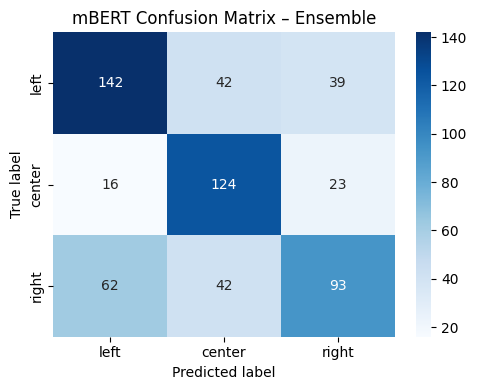

In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# Report
print("\n ENSEMBLE CLASSIFICATION REPORT:")
print(classification_report(
        y_true,
        # ensemble predictions
        y_pred_ens,                          
        target_names=[id2label[i] for i in range(len(id2label))]
))


cm_ens = confusion_matrix(y_true, y_pred_ens)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_ens,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=[id2label[i] for i in range(len(id2label))],
    yticklabels=[id2label[i] for i in range(len(id2label))]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("mBERT Confusion Matrix - Ensemble")   
plt.tight_layout()
plt.show()


### MBert Baseline

In [ ]:
# Baseline pre-trained model with no fine-tuning performance
print("\n Baseline (pre-trained mBERT) evaluation...")

baseline_model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-multilingual-cased",    
        num_labels=3,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True        
)

baseline_trainer = Trainer(
    model=baseline_model,
    tokenizer=tokenizer,                   
    compute_metrics=compute_metrics        
)

baseline_preds  = baseline_trainer.predict(test_ds)
baseline_logits = baseline_preds.predictions           
baseline_labels = baseline_preds.label_ids             
baseline_y_pred = np.argmax(baseline_logits, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("\n BASELINE (mBERT) Classification Report:")
print(classification_report(
        baseline_labels,
        baseline_y_pred,
        target_names=[id2label[i] for i in range(3)]
))

cm_base = confusion_matrix(baseline_labels, baseline_y_pred)
print("\nConfusion Matrix – Baseline (mBERT):\n", cm_base)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-20-319804288.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



 Baseline (pre-trained mBERT) evaluation...



 BASELINE (mBERT) Classification Report:
              precision    recall  f1-score   support

        left       0.00      0.00      0.00       223
      center       0.38      0.02      0.04       163
       right       0.34      0.99      0.51       197

    accuracy                           0.34       583
   macro avg       0.24      0.34      0.18       583
weighted avg       0.22      0.34      0.18       583


Confusion Matrix – Baseline (mBERT):
 [[  0   4 219]
 [  0   3 160]
 [  0   1 196]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### MBert Baseline vs Fine-Tuned

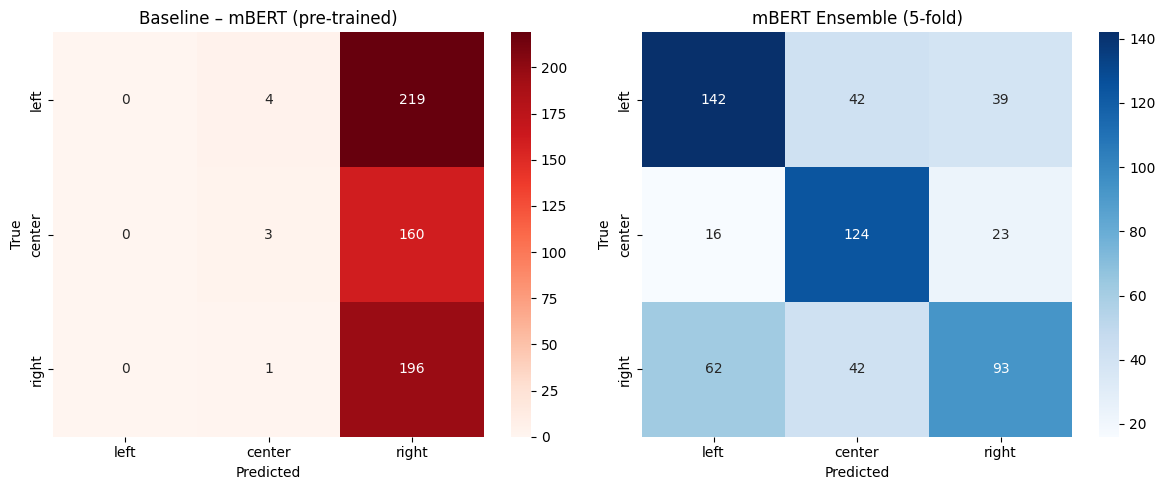

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline pre trained mBERT
sns.heatmap(
    cm_base,                           
    annot=True, fmt="d", cmap="Reds",
    xticklabels=[id2label[i] for i in range(3)],
    yticklabels=[id2label[i] for i in range(3)],
    ax=axes[0]
)
axes[0].set_title("Baseline - mBERT (pre-trained)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Ensemble 5-fold fine-tuned mBERT
sns.heatmap(
    cm_ens,                            
    annot=True, fmt="d", cmap="Blues",
    xticklabels=[id2label[i] for i in range(3)],
    yticklabels=[id2label[i] for i in range(3)],
    ax=axes[1]
)
axes[1].set_title("mBERT Ensemble (5-fold)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


## Mistral-7B-Instruct-v0.2-turkish

### Mistral CV ensemble soft voting

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/2330 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/583 [00:00<?, ? examples/s]


===== FOLD 1/5 =====


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at malhajar/Mistral-7B-Instruct-v0.2-turkish and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-547849996.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 65,024,000 || all params: 7,175,696,384 || trainable%: 0.9062


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,3.966800,0.824814,0.635193,0.504737
2,3.105000,1.460488,0.281116,0.146287
3,2.611400,0.950407,0.635193,0.504737
4,2.059300,1.288448,0.336910,0.168004



===== FOLD 2/5 =====


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at malhajar/Mistral-7B-Instruct-v0.2-turkish and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-547849996.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 65,024,000 || all params: 7,175,696,384 || trainable%: 0.9062


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,5.284100,1.144565,0.336910,0.168004
2,2.663600,1.100632,0.381974,0.184265
3,2.411500,1.123508,0.381974,0.184265
4,3.167500,0.869966,0.579399,0.441921
5,1.865800,0.752326,0.641631,0.510091
6,1.709700,0.719618,0.635193,0.509836
7,1.691600,0.791424,0.641631,0.510091
8,1.596200,0.732102,0.618026,0.552620
9,1.452500,0.757333,0.592275,0.574573



===== FOLD 3/5 =====


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at malhajar/Mistral-7B-Instruct-v0.2-turkish and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-547849996.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 65,024,000 || all params: 7,175,696,384 || trainable%: 0.9062


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,4.267300,1.521783,0.339056,0.171999
2,1.874400,0.964519,0.639485,0.511937
3,2.053200,0.775718,0.639485,0.508317
4,8.309800,2.039622,0.566524,0.522376
5,4.772500,0.756813,0.639485,0.508317
6,1.689400,0.765642,0.639485,0.515446
7,1.782500,0.737594,0.639485,0.592645
8,1.579000,0.810585,0.379828,0.278870
9,1.550200,0.728919,0.641631,0.516787
10,1.523100,0.702532,0.654506,0.573598



===== FOLD 4/5 =====


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at malhajar/Mistral-7B-Instruct-v0.2-turkish and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-547849996.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 65,024,000 || all params: 7,175,696,384 || trainable%: 0.9062


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,3.997600,1.268551,0.336910,0.168004
2,2.915000,1.358709,0.336910,0.168004
3,2.744600,1.213197,0.381974,0.184265
4,2.533600,1.097631,0.381974,0.184552
5,2.853800,1.373717,0.281116,0.146287
6,2.607000,1.215908,0.381974,0.184265
7,2.473400,1.167659,0.336910,0.168004



===== FOLD 5/5 =====


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at malhajar/Mistral-7B-Instruct-v0.2-turkish and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-547849996.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 65,024,000 || all params: 7,175,696,384 || trainable%: 0.9062


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,4.013400,1.026979,0.403433,0.352732
2,2.654200,2.326237,0.384120,0.185013
3,2.514300,1.117942,0.287554,0.205402
4,2.431400,1.705981,0.336910,0.168004



===== CV MEAN METRICS =====
eval_loss                   0.873401
eval_accuracy               0.543777
eval_f1_macro               0.432205
eval_runtime               12.281860
eval_samples_per_second    37.941800
eval_steps_per_second       4.803800
epoch                       7.800000
dtype: float64

 ENSEMBLE – Mistral-LoRA:
              precision    recall  f1-score   support

        left       0.69      1.00      0.82       223
      center       0.60      0.94      0.73       163
       right       1.00      0.01      0.01       197

    accuracy                           0.65       583
   macro avg       0.76      0.65      0.52       583
weighted avg       0.77      0.65      0.52       583



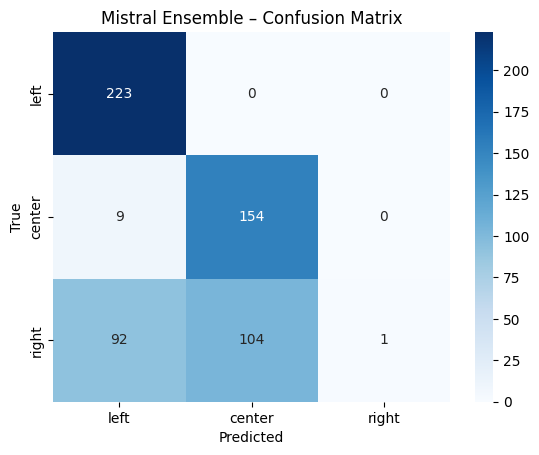

 logits_mistral.npy and test_labels.npy saved


In [ ]:
# Libs and config
import os, gc, random, torch, numpy as np, pandas as pd, evaluate, seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from peft import LoraConfig, get_peft_model

# enable TF32 matmuls on A100 GPUs for faster training
torch.backends.cuda.matmul.allow_tf32 = True          

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# hyperparameters
MODEL_NAME   = "malhajar/Mistral-7B-Instruct-v0.2-turkish"
MAX_LENGTH   = 256
# per gpu batch size
PER_DEV_BS   = 8
# effective batch size = PER_DEV_BS * GRAD_ACCUM          
GRAD_ACCUM   = 2
# early stopping will stop earlier if needed          
NUM_EPOCHS   = 15         
LEARNING_RATE= 3e-4
N_SPLITS     = 5

# Tokenizer and Datasets
# Mistral is a decoder-only model so we still use a standard tokenizer
# We set a pad token that falls back to the EOS token to make the batching clean
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tok.pad_token = tok.eos_token if tok.pad_token is None else tok.pad_token

def tokenize(batch):
    # truncate and pad to a fixed window so that the model can handle it
    return tok(batch["Content"],
               truncation=True,
               padding="max_length",
               max_length=MAX_LENGTH)

# prepare the Hugging Face Datasets once to avoid repeating map inside Cv loop
train_val_ds = Dataset.from_pandas(temp_df.reset_index(drop=True)) \
               .map(tokenize, batched=True, num_proc=4)            \
               .remove_columns("Content").with_format("torch")

test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))      \
           .map(tokenize, batched=True, num_proc=4)                \
           .remove_columns("Content").with_format("torch")

# LoRA model
# we start with a pre-trained Mistral model
# use PEFT and LoRA to avoid full fine-tuning basically we freeze the base weights
# and insert small low-rank adapters into selected linear layers
# then we only train those adapter weights. 
# this is VRAM efficient and fast
def build_lora_model():
    base = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id,
        # bfloat 16 is fast and stable on A100
        torch_dtype=torch.bfloat16,
        # let HuggingFace handle the device placement
        device_map="auto"
    )

    # make sure the pad token id is set
    if base.config.pad_token_id is None:
        base.config.pad_token_id = tok.pad_token_id

    lora_cfg = LoraConfig(
        # rank of the adapter matrices
        r=32,
        #scaling LoRA updates
        lora_alpha=64,
        # regularize adapters to avoid overfitting
        lora_dropout=0.1,
        # by targeting attention projectors and the MLP layers we can reduce the model size
        target_modules=["q_proj","k_proj","v_proj","o_proj",
                        "gate_proj","up_proj"],
        bias="none",
        task_type="SEQ_CLS"
    )
    # this wraps the base model and marks only the LoRA layers as trainable
    return get_peft_model(base, lora_cfg)

# Metrics
#simple, consistent metrics across all modell families
accuracy = evaluate.load("accuracy"); f1_mac = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy":  accuracy.compute(predictions=preds, references=labels)["accuracy"],
            "f1_macro": f1_mac.compute(predictions=preds, references=labels,
                                       average="macro")["f1"]}

# Cross Validation Loop
# Standard 5-fold CV on the shared train + val dataset
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
fold_metrics = []

# where each fold's logits will be saved
LOG_DIR = "mistral_logits"          
os.makedirs(LOG_DIR, exist_ok=True)

for fold,(tr_idx,vl_idx) in enumerate(skf.split(temp_df["Content"], temp_df["label"]),1):
    print(f"\n===== FOLD {fold}/{N_SPLITS} =====")
    tr_ds = train_val_ds.select(tr_idx)
    vl_ds = train_val_ds.select(vl_idx)

    model = build_lora_model()
    # sanity check to see trainable parameters
    model.print_trainable_parameters()

    args = TrainingArguments(
        output_dir               = f"./mistral_cv_fold_{fold}",
        eval_strategy      = "epoch",
        logging_strategy         = "epoch",
        save_strategy            = "epoch",
        save_total_limit         = 1,
        load_best_model_at_end   = True,
        metric_for_best_model    = "eval_loss",
        greater_is_better        = False,
        num_train_epochs         = NUM_EPOCHS,
        per_device_train_batch_size = PER_DEV_BS,
        per_device_eval_batch_size  = PER_DEV_BS,
        # gradient accumulation gives effecive batch size of 16
        gradient_accumulation_steps = GRAD_ACCUM,
        learning_rate            = LEARNING_RATE,
        # cosine LR scheduler with warmup is a good default for adapter tuning
        lr_scheduler_type        = "cosine",
        warmup_ratio             = 0.06,
        weight_decay             = 0.05,
        # bf16 +TF32 makes training faster on A100
        bf16                     = True,
        optim                    = "adamw_torch",
        dataloader_num_workers   = 4,
        seed                     = SEED,
        report_to                = []
    )

    trainer = Trainer(
        model=model,
        args =args,
        train_dataset = tr_ds,
        eval_dataset  = vl_ds,
        tokenizer     = tok,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    fold_metrics.append(trainer.evaluate())

    # Test Prediction + Logit Dump
    # We save raw logits 
    # later we mean average them
    test_logits = trainer.predict(test_ds).predictions.astype("float32")
    np.save(f"{LOG_DIR}/fold{fold}.npy", test_logits)  

    # free VRAM after each fold
    del model, trainer; gc.collect(); torch.cuda.empty_cache()

# CV Summary
cv_df = pd.DataFrame(fold_metrics)
print("\n===== CV MEAN METRICS ====="); print(cv_df.mean())

# Ensemble and Test
# simple soft-voting 
# we load the logits from each fold and average them then argmax
all_logits = []
for fold in range(1, N_SPLITS+1):
    all_logits.append(np.load(f"{LOG_DIR}/fold{fold}.npy"))

avg_logits = np.mean(np.stack(all_logits, axis=0), axis=0)  # (N_test, n_labels)
y_pred_ens = np.argmax(avg_logits, axis=1)
y_true     = test_ds["label"]

print("\n ENSEMBLE - Mistral-LoRA:")
print(classification_report(y_true, y_pred_ens,
                            target_names=[id2label[i] for i in range(len(id2label))]))

# Confusion Matrix
cm_ens = confusion_matrix(y_true, y_pred_ens)
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Mistral Ensemble - Confusion Matrix"); plt.show()

# Logit dump
# keep a single averaged logits file for downstream ensemble of models
np.save("logits_mistral.npy", avg_logits)
if not os.path.exists("test_labels.npy"):
    np.save("test_labels.npy", y_true)
print("logits_mistral.npy and test_labels.npy saved")


### Baseline (no fine tuning mistral)


 Baseline – Mistral (pre-trained) evaluation...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at malhajar/Mistral-7B-Instruct-v0.2-turkish and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-18-4003240368.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



 BASELINE Classification Report (Mistral pre-trained):
              precision    recall  f1-score   support

        left       0.39      0.30      0.34       223
      center       0.28      0.37      0.32       163
       right       0.33      0.32      0.32       197

    accuracy                           0.33       583
   macro avg       0.33      0.33      0.33       583
weighted avg       0.34      0.33      0.33       583



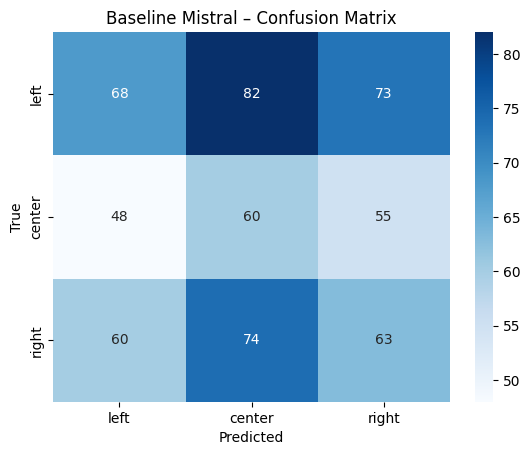

 logits_mistral_baseline.npy saved


In [ ]:
# Baseline pre-trained model evaluation
print("\n Baseline – Mistral (pre-trained) evaluation...")

# do not fine tune the model, just use the pre-trained weights
baseline_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels = len(id2label),
        id2label   = id2label,
        label2id   = label2id,
        device_map = "auto",          # or "cpu"
        torch_dtype= torch.bfloat16   # fp16/bf16, no 4-bit
)

# ensure the pad token is set for clean batching
if baseline_model.config.pad_token_id is None:
    baseline_model.config.pad_token_id = tok.pad_token_id


baseline_trainer = Trainer(
    model    = baseline_model,
    tokenizer= tok
)

# run inference on the hold-out test set
base_preds   = baseline_trainer.predict(test_ds)
base_logits  = base_preds.predictions           
base_labels  = base_preds.label_ids
base_y_pred  = np.argmax(base_logits, axis=1)

print("\n BASELINE Classification Report (Mistral pre-trained):")
print(classification_report(
        base_labels,
        base_y_pred,
        target_names=[id2label[i] for i in range(len(id2label))]
))

cm_base = confusion_matrix(base_labels, base_y_pred)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Baseline Mistral – Confusion Matrix")
plt.show()

# Logits dump
np.save("logits_mistral_baseline.npy", base_logits.astype("float32"))
print(" logits_mistral_baseline.npy saved")

### Baseline vs Ensemble Confusion Matrix

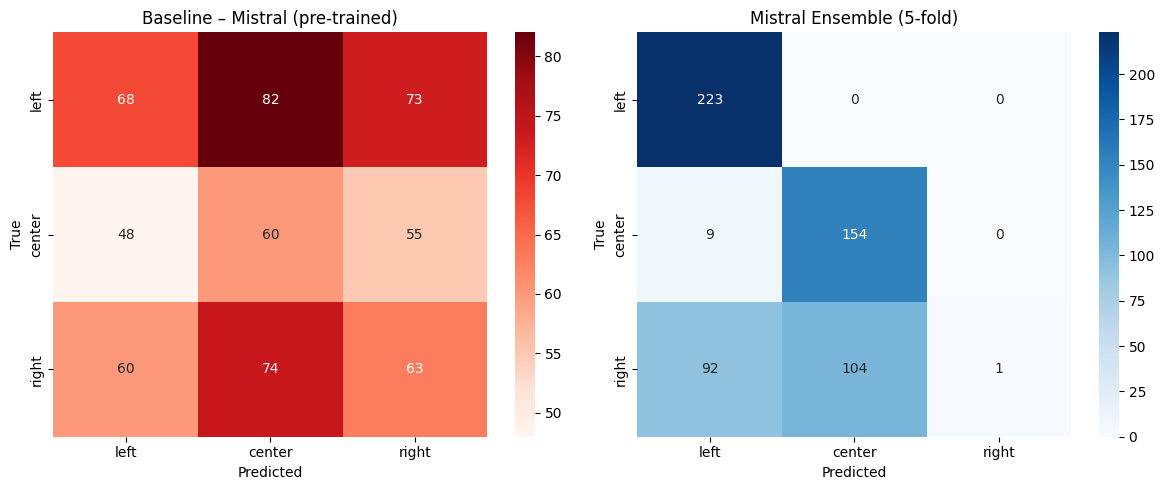

In [ ]:
# Confusion Matrix Comparison
import matplotlib.pyplot as plt, seaborn as sns

# Take class labels from id2label
n_cls   = len(id2label)                    
ticklab = [id2label[i] for i in range(n_cls)]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline
sns.heatmap(
    cm_base, annot=True, fmt="d", cmap="Reds",
    xticklabels=ticklab, yticklabels=ticklab,
    ax=axes[0]
)
axes[0].set_title("Baseline – Mistral (pre-trained)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

# Ensemble
sns.heatmap(
    cm_ens, annot=True, fmt="d", cmap="Blues",
    xticklabels=ticklab, yticklabels=ticklab,
    ax=axes[1]
)
axes[1].set_title("Mistral Ensemble (5-fold)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout(); plt.show()


## Ensemble Evaluation

  Saved per-model votes to model_votes.csv

 Ensemble results
              precision    recall  f1-score   support

        left     0.8122    0.7175    0.7619       223
      center     0.7647    0.7975    0.7808       163
       right     0.6343    0.6954    0.6634       197

    accuracy                         0.7324       583
   macro avg     0.7370    0.7368    0.7354       583
weighted avg     0.7388    0.7324    0.7339       583

Accuracy: 0.7324


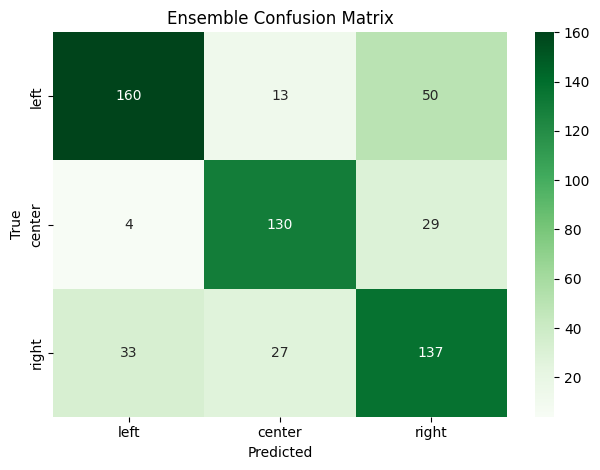

In [ ]:
# Ensemble evaluation
import numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns, matplotlib.pyplot as plt

# Load per model test logits and the shared ground-truth labels
logits_bt  = np.load("logits_bertturk_ens.npy")
logits_xl  = np.load("logits_xlmr.npy")
logits_mb  = np.load("logits_mbert.npy")
logits_mi  = np.load("logits_mistral.npy")
y_true     = np.load("test_labels.npy")

# Save each model's predictions
df_votes = pd.DataFrame({
    "true"      : y_true,
    "bt_pred"   : np.argmax(logits_bt, axis=1),
    "xlmr_pred" : np.argmax(logits_xl, axis=1),
    "mbert_pred": np.argmax(logits_mb, axis=1),
    "mistral_pred": np.argmax(logits_mi, axis=1)
})

df_votes.to_csv("model_votes.csv", index=False)
print("Saved per-model votes to model_votes.csv")

# Soft voting across model families 
# arithmetic mean of logits
ensemble_logits = (logits_bt + logits_xl + logits_mb +logits_mi) / 4
y_ens           = np.argmax(ensemble_logits, axis=1)

# Metrics
print("\n Ensemble results")
print(classification_report(
    y_true, y_ens,
    target_names=["left","center","right"],
    digits=4))

print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_ens)))

cm = confusion_matrix(y_true, y_ens)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["left","center","right"],
            yticklabels=["left","center","right"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Ensemble Confusion Matrix"); plt.tight_layout(); plt.show()


### Without mistral

  Saved per-model votes to model_votes_without_mistral.csv

 Ensemble results
              precision    recall  f1-score   support

        left     0.7475    0.6637    0.7031       223
      center     0.6944    0.7669    0.7289       163
       right     0.6341    0.6599    0.6468       197

    accuracy                         0.6913       583
   macro avg     0.6920    0.6968    0.6929       583
weighted avg     0.6944    0.6913    0.6913       583

Accuracy: 0.6913


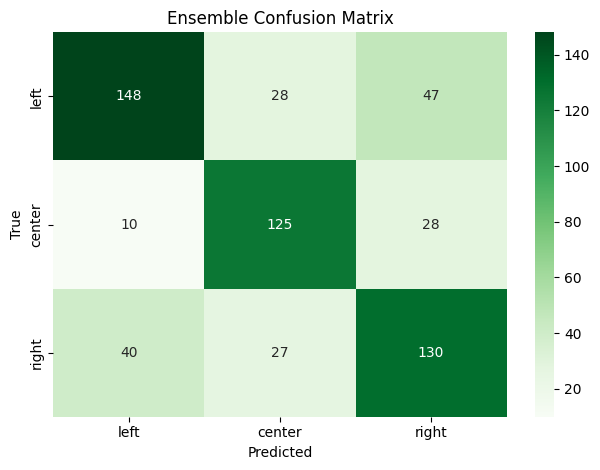

In [ ]:
# Ensemble evaluation without Mistral
import numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns, matplotlib.pyplot as plt

# Load per model test logits except Mistral
logits_bt  = np.load("logits_bertturk_ens.npy")
logits_xl  = np.load("logits_xlmr.npy")
logits_mb  = np.load("logits_mbert.npy")
y_true     = np.load("test_labels.npy")

# 2)  Save each model's predictions without Mistral
df_votes = pd.DataFrame({
    "true"      : y_true,
    "bt_pred"   : np.argmax(logits_bt, axis=1),
    "xlmr_pred" : np.argmax(logits_xl, axis=1),
    "mbert_pred": np.argmax(logits_mb, axis=1),
    "mistral_pred": np.argmax(logits_mi, axis=1)
})

df_votes.to_csv("model_votes_without_mistral.csv", index=False)
print(" Saved per-model votes to model_votes_without_mistral.csv")

# soft voting across model families 
ensemble_logits = (logits_bt + logits_xl + logits_mb) / 3
y_ens           = np.argmax(ensemble_logits, axis=1)

# Metrics
print("\n Ensemble results")
print(classification_report(
    y_true, y_ens,
    target_names=["left","center","right"],
    digits=4))

print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_ens)))

cm = confusion_matrix(y_true, y_ens)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["left","center","right"],
            yticklabels=["left","center","right"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Ensemble Confusion Matrix"); plt.tight_layout(); plt.show()
